# EPA112 Programming for Data Science: Exploring the Relationship Between Gender Equality and Environmental Sustainability Beyond Geographical Clusters
### Group 42: Angelica (6556671), Elena Deckert (6580300), Tadas Lukavicius(5525047)

# 1. Introduction

In recent years, the global community has increasingly recognized that social and environmental progress are deeply interconnected (Ko & Leung, 2025). Achieving sustainable development requires not only protecting the environment but also ensuring equality and inclusion for all people. The United Nations Sustainable Development Goals (SDGs) reflect this interdependence, particularly SDG 5 (Gender Equality) and SDG 13 (Climate Action). While gender equality and environmental sustainability are often discussed separately, their relationship remains complex and not fully understood at a global scale.

Understanding how these two dimensions interact is crucial for designing effective and inclusive sustainability policies (IUCN, 2024). Evidence suggests that gender-inclusive societies tend to adopt more progressive environmental policies, strengthen climate action, and engage more effectively in sustainable resource governance. At the same time, structural gender inequalities can limit countries’ capacities to address environmental challenges by restricting participation, access to knowledge, and equitable distribution of resources. However, cross-country progress in these areas is uneven, and it is far from clear whether improvements in one domain consistently accompany progress in the other. Some countries may advance ambitious environmental agendas without parallel gains in gender equality, while others strengthen social equity without translating these gains into environmental outcomes.

Research increasingly shows that addressing gender inequality is a structural prerequisite for holistic ESG (Environmental, Social, and Governance) progress (Ko & Leung, 2025). Integrating gender equality into conservation, climate action, and sustainable development empowers women as agents of change, which in turn leads to improved environmental, health, and socioeconomic outcomes. Specifically, countries with higher female parliamentary representation often: adopt more progressive environmental regulations, strengthen climate policies and implementation, improve natural resource governance and conservation.

Unfortunately, progress is complicated by regional and institutional variations. The impact of gender inequality on ESG performance is often strongest in upper-middle-income countries and can vary by governance context. These patterns highlight that advances in social or environmental dimensions may be decoupled, with local institutional contexts mediating outcomes. We aim to further explore these regional differences.

Problem statement:
Despite the emphasis on integrated development in international frameworks, systematic knowledge remains limited on how improvements in gender equality align with environmental progress, which regions lead or lag in integrated sustainability, and which countries show divergent trajectories. To address this, this project aims to visualize patterns between countries to better understand these relationships and assess whether the observed data aligns with existing research.

To address this question, this project conducts a comprehensive exploratory data analysis using global indicators for gender equality (e.g., GII, female education, labor participation) and environmental sustainability (e.g., renewable energy adoption, pollution, species and habitat protection). We examine distributions, temporal trends, correlations, and regional differences to uncover patterns, identify outliers, and assess the dynamics of progress over time. By combining clustering techniques with temporal and spatial analyses, this study seeks to reveal nuanced relationships between gender equality and environmental sustainability.

## 1.1 Research Questions
Throughout our analysis we aim to address the following research questions:
- What are the global patterns of gender inequality, and how do they differ across regions? How do gender inequality trends evolve over time in different parts of the world?
  
- What are the global patterns of environmental sustainability, and how do they differ across regions? How do environmental sustainability trends evolve over time in different parts of the world?

- To what extent do environmental sustainability correlate with patterns of gender inequality?

- How do countries cluster based on combined indicators of gender equality and environmental sustainability, and how have these clusters evolved over time?

- Do improvements in gender equality (e.g., education, labour participation, political representation) align with improvements in environmental sustainability (e.g., renewable energy share, species protection, pollution reduction)?

- Which indicators most strongly drive the formation of sustainability–equality clusters?

- How do regional patterns compare to data-driven clusters — do countries within the same continent tend to belong to the same development cluster, or do they diverge significantly?



## 1.2 Library Imports
This cell installs all the necessary additional libraries.

In [ ]:
!pip install pycountry -q
!pip install pycountry-convert -q
!pip install wbdata -q
!pip install ipywidgets -q
!pip install plotly -q
!pip install scikit-learn -q

This cell imports all the necessary libraries

In [295]:
import logging
import warnings
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import pycountry_convert
import json
from data_handler import Data_Handler
from completeness import Completeness_Ranker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px

# 2. Datasets

## 2.1 WBData completeness analysis

First, we completed a completeness analysis on the World Bank data. This was done because the data provided by the World Bank had a lot of factors; however, a lot of them had a lot of missing data. This was done by selecting the indicators that we were interested in, namely:
- Gender Disaggregated Labour Database (GDLD)
- Country Climate and Development Report (CCDR)
- Sustainable Development Goals
- Sustainable Energy for All
- Gender Statistics 

For each of these categories, we got all the data and checked how many NaN values there were per factor. This gave us valuable insight into which data can provide the most information for our further research.

In the next cell, we provide an example of such an analysis for the _Sustainable Energy for All_ indicator. We wanted to avoid clutter in this notebook, so the complete analysis can be found in the "WBData explore" notebook.

In [296]:
se_summary, se_df = Completeness_Ranker.rank_indicators_by_completeness(35, 2000, 2025, 10)
print(se_summary.head(15))

Found 11 indicators in source 35
Fetching data for all indicators...


Fetching indicators: 100%|█████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.95it/s]


Retrieved 39126 data points


Calculating completeness: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 160.63it/s]

                    Indicator Code  \
1    1.1_TOTAL.FINAL.ENERGY.CONSUM   
6               3.1_RE.CONSUMPTION   
8     4.1.2_REN.ELECTRICITY.OUTPUT   
9      4.1_SHARE.RE.IN.ELECTRICITY   
0       1.1_ACCESS.ELECTRICITY.TOT   
3     1.3_ACCESS.ELECTRICITY.URBAN   
7   4.1.1_TOTAL.ELECTRICITY.OUTPUT   
5       2.1_SHARE.TOTAL.RE.IN.TFEC   
2     1.2_ACCESS.ELECTRICITY.RURAL   
4               2.1_ACCESS.CFT.TOT   
10    6.1_PRIMARY.ENERGY.INTENSITY   

                                       Indicator Name  Completeness  \
1               Total final energy consumption (TFEC)      0.610782   
6                   Renewable energy consumption (TJ)      0.610782   
8           Renewable energy electricity output (GWh)      0.610618   
9   Renewable electricity (% in total electricity ...      0.610618   
0       Access to electricity (% of total population)      0.604043   
3       Access to electricity (% of urban population)      0.604043   
7                      Total electricity outpu

## 2.2 Pulling the data

Next, we chose data depending on their completeness and interest in our research.

From the World Bank data, we chose:
- Renewable energy share: Renewable electricity share of total electricity output (%): Electricity generated by power plants using renewable resources as a share of total electricity output.
- Basic drinking water:	The percentage of people using at least basic water services. This indicator encompasses both people using basic water services as well as those using safely managed water services.

From the Environmental Performance Index by Yale, we chose:
- Species protection index: measures how well a country's terrestrial protected areas overlap with the ranges of its vertebrate, invertebrate, and plant species.
- Air Pollution SO2 trend: measures exposure to ground-level sulfur dioxide using a country’s ambient ground-level concentration.
- Ambient PM2.5 from human resources: measures the exposure to fine particulate matter pollution from anthropogenic sources, such as the burning of fossil fuels, which are easier to influence through policy than natural sources.
- Marine Habitat Protection: measures the percentage of the area of important marine and coastal habitats under official protection within a country’s Exclusive Economic Zone(s).

From the Human Development Index by the United Nations, we chose:
- GII: composite metric of gender inequality using three dimensions: reproductive health, empowerment and the labour market. A low GII value indicates low inequality between women and men, and vice versa.
- Shares of seats in the parliament, female: percentage of parliamentary seats held by women.
- Labour force participation, female: percentage of women who are working or actively seeking work.
- Population with secondary education, female: percentage of women who have completed secondary education.

Note: We had to download the Renewable energy consumption share data separately because the API from the World Bank had incomplete data. The data retrieved via the API had no data after 2015; thus, we downloaded the data separately and imported it.

In the next cell, we get the said data from according sources.

In [297]:
# Initialise data indicators and relative names for the columns in the data
indicators_wb = { "SH.H2O.BASW.ZS" :  "Basic drinking water"}
indicators_yale = { "SPI" : "Species protection index",
              "SDA" : "Air Polution SO2 trend",
              "HPE" : "Ambient PM2.5 from human resources", 
              "MHP" : "Marine Habitat Protection"}
indicators_hdi = {"gii" : "GII",
                 "pr_f" : "Shares of seats in the parliament, female",
                 "lfpr_f" : "Labour force participation, female",
                 "se_f" : "Population with secondary education, female"}

# Get world bank data
wbdata = Data_Handler.get_data_WB(
    indicators_wb, 
    countries="all", 
    start_year=1990, 
    end_year=2024
 )
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=1990,
    end_year=2024
)
# Get EPI data
epi_data = Data_Handler.get_data_EPI(
    indicators=indicators_yale,
    countries=None,
    start_year=1990,
    end_year=2024
)

re_data = Data_Handler.get_renewable_energy_data(
    file_path="API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_130800.csv",
    start_year=1990,
    end_year=2024
)

In the next cell, we merge all data into one dataframe.

In [298]:
# Rename columns for consistency
wbdata.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)

# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['country', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Pivot the EPI dataset 
epi_data_pivot = epi_data.pivot_table(
    index=['country', 'year'],
    columns='variable_name',     # Each variable_name becomes a column
    values='value'
).reset_index()

# Merge all three datasets on 'country' and 'year'
data = (
    wbdata
    .merge(hdi_data_pivot, on=['country', 'year'], how='outer')
    .merge(epi_data_pivot, on=['country', 'year'], how='outer')
    .merge(re_data, on=['country', 'year'], how='outer')
)

## 2.3 Data preprocessing

In this section, we complete all necessary data preprocessing.

To get a standardised list of country names, we will be using pycountry. This library contains an ISO list of country names. Additionally, some "countries' are actually regions (e.g. Eurozone, the world, etc), so we skipped those as we are interested in the dynamics between different countries. We used a mapping of countries that were picked manually, because different datasets had different names for countries (e.g. "Czezh Republic" and "Czechia"), which was saved in a JSON format in the file country_names_mapping.json. This approach was done in order to reduce clutter in the notebook.

In [299]:
# Create a set of official country names from the pycountry library
pycountry_names = set([c.name for c in pycountry.countries])
country_map = {}
for name in data['country'].unique():
    if name in pycountry_names:
        country_map[name] = name

# Load a mapping file that contains manual corrections for country names not recognised by pycountry
with open("country_names_mapping.json", "r", encoding="utf-8") as f:
    map_update = json.load(f)

# Update the country_map with custom name mappings
country_map.update(map_update)
data['country'] = data['country'].map(country_map)

# Drop rows where 'country' is NaN
data = data.dropna(subset=['country'])

# Group by country and year to ensure unique records per pair
# If there are duplicates, `.first()` keeps the first occurrence
data = data.groupby(['country', 'year'], as_index=False).first()


In the next cell, we make a continent variable, which will later help us identify patterns between different continents.

In [300]:
def get_continent(country_name):
    try:
        # Try to find the country by exact name first
        country = pycountry.countries.get(name=country_name)
        
        # If not found, try fuzzy search
        if country is None:
            country = pycountry.countries.search_fuzzy(country_name)[0]
        
        # Get ISO Alpha-2 code
        country_code = country.alpha_2
        
        # Convert to continent code and name
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code)
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        
        return continent_name

    except Exception:
        return 'Unknown'

# Apply to your DataFrame
data['continent'] = data['country'].apply(get_continent)

After the previous cell, due to the mismatch between the names in the pycountry list and the dataset, a few countries were not identified. For these countries, we assigned the continent manually. This was done in the next two cells.

In [301]:
unknown_continent_countries = data[
    (data['continent'].isna()) | (data['continent'] == 'Unknown')
][['country']].drop_duplicates()

print(unknown_continent_countries)

                               country
1709  Democratic Republic Of The Congo
1884                        East Timor
3979                  Macao SAR, China
6108         Sint Maarten (Dutch part)
7288                    Western Sahara


In [302]:
data.loc[data["country"] == "Democratic Republic Of The Congo", "continent"] = "Africa"
data.loc[data["country"] == "Macao SAR, China", "continent"] = "Asia"
data.loc[data["country"] == "Sint Maarten (Dutch part)", "continent"] = "North America"
data.loc[data["country"] == "Western Sahara", "continent"] = "Africa"
data.loc[data["country"] == "East Timor", "continent"] = "Asia"

Later, we plotted the missing values by year in a bar graph.

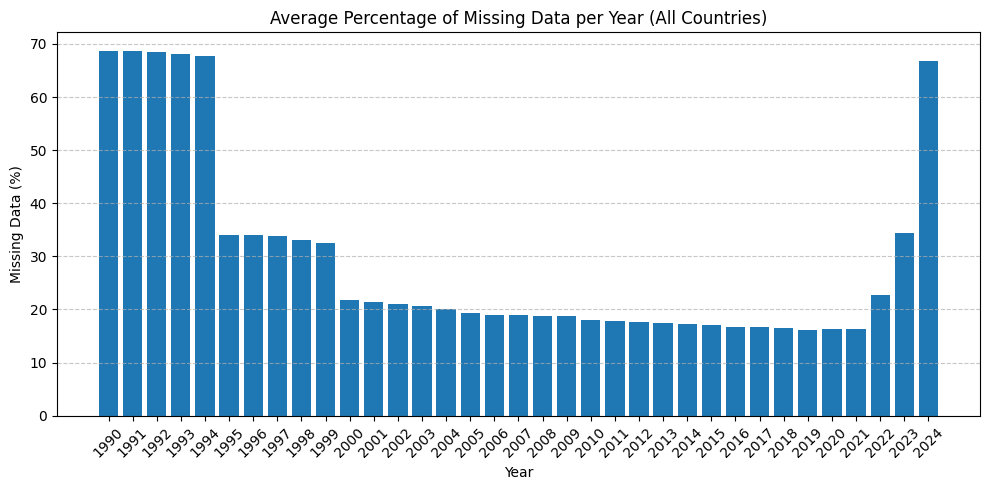

In [303]:
# Exclude trivial columns
cols_to_check = [c for c in data.columns if c not in ['year', 'country', 'continent']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see from the bar graph, a lot of the missing data is before 2000 and after 2022, thus, we have decided to exclude this data from our dataset.

In [304]:
data = data[(data['year'] >= 2000) & (data['year'] <= 2022)]

Next, we plot countries and the percentage of missing values per country.

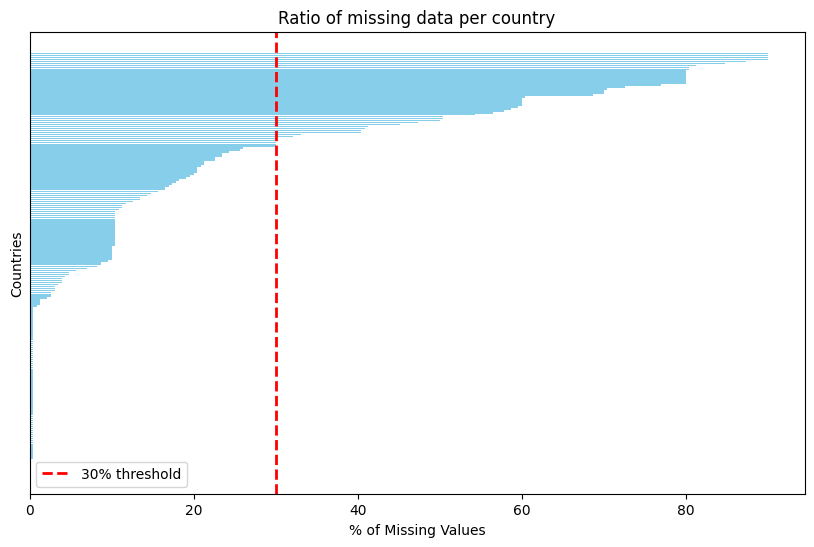

In [305]:
# Get NaN values by country
nan_by_country = data.groupby('country')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Ratio of missing data per country')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.

In [306]:
def nan_mean_excluding_marine(x):
    # Exclude 'Marine Habitat Protection' if all NaN for this country
    if 'Marine Habitat Protection' in x.columns and x['Marine Habitat Protection'].isna().all():
        return x.drop(columns=['Marine Habitat Protection']).isna().mean().mean() * 100
    else:
        return x.isna().mean().mean() * 100
before_excl = len(data["country"].unique())
# Compute missing-data percentage per country
country_nan_percent = data.groupby('country')[cols_to_check].apply(nan_mean_excluding_marine)

# Keep only countries with <= 30% missing data
valid_countries = country_nan_percent[country_nan_percent <= 30].index

# Filter the main DataFrame
data = data[data['country'].isin(valid_countries)]
after_excl = len(data["country"].unique())

print(f"{before_excl - after_excl} countries removed from the data.")

43 countries removed from the data.


Now, we want to inspect the trends of missing data between different factors in our dataset.

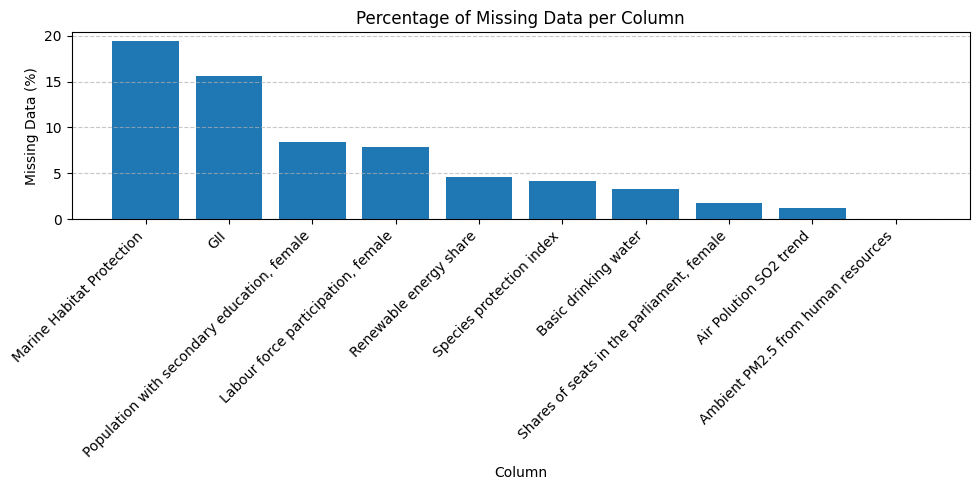


Missing data percentage per column (sorted):
Marine Habitat Protection                      19.411765
GII                                            15.652174
Population with secondary education, female     8.363171
Labour force participation, female              7.877238
Renewable energy share                          4.578005
Species protection index                        4.117647
Basic drinking water                            3.324808
Shares of seats in the parliament, female       1.790281
Air Polution SO2 trend                          1.176471
Ambient PM2.5 from human resources              0.000000
dtype: float64


In [307]:
# Get NaN values per column
nan_per_column = data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

The highest factor in missing data is for Marine Habitat Protection. That is because there are landlocked countries, for example, Slovakia, which do not have access to seas or Oceans, and thus cannot have any marine habitat protection.

## 2.4 Uniformize data

Next, we look at the minimum and maximum values each column can obtain. All factors except for GII are measured from 0 to 100. We have decided to multiply the GII by a factor of 100, as this will later help us visualise the results.

In [308]:
# Print min and max values of each column
min_max = data.agg(['min', 'max']).transpose().reset_index()
min_max.columns = ['Column', 'Min', 'Max']
print(min_max)

# Multiply GII by a 100
data['GII'] = data['GII'] * 100

                                         Column          Min            Max
0                                       country  Afghanistan       Zimbabwe
1                                          year         2000           2022
2                          Basic drinking water    18.682303          100.0
3                                           GII        0.004           0.84
4            Labour force participation, female         5.72           94.4
5   Population with secondary education, female     1.761277          100.0
6     Shares of seats in the parliament, female          0.0       57.54717
7                        Air Polution SO2 trend          0.0          100.0
8            Ambient PM2.5 from human resources          0.0          100.0
9                     Marine Habitat Protection          0.0          100.0
10                     Species protection index          0.0          100.0
11                       Renewable energy share          0.0           96.0
12          

## 2.5 Basic Stats

Next we tried to get a general overview of the numeric value columns.

In [309]:
# Get a basic description of numeric values
data.describe()

,year,Basic drinking water,GII,"Labour force participation, female","Population with secondary education, female","Shares of seats in the parliament, female",Air Polution SO2 trend,Ambient PM2.5 from human resources,Marine Habitat Protection,Species protection index,Renewable energy share
count,3910.000000,3780.000000,3298.000000,3602.000000,3583.000000,3840.000000,3864.000000,3910.000000,3151.000000,3749.000000,3731.000000
mean,2011.000000,85.716722,37.075591,50.124606,55.265431,18.876819,66.454451,43.563964,22.111933,36.525020,32.332485
std,6.634098,17.610250,19.620179,15.601038,30.642818,11.432121,32.417434,30.444452,22.481686,27.474321,29.029545
min,2000.000000,18.682303,0.400000,5.720000,1.761277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,77.797856,19.300000,41.802500,27.016138,10.000000,41.800000,19.700000,3.700000,13.000000,7.300000
50%,2011.000000,93.756772,38.100000,51.600000,56.299999,17.449664,70.850000,37.100000,16.000000,32.200000,23.900000
75%,2017.000000,99.124099,53.100000,59.207500,85.219448,25.903614,100.000000,64.850000,35.400000,57.400000,52.000000
max,2022.000000,100.000000,84.000000,94.400000,100.000000,57.547170,100.000000,100.000000,100.000000,100.000000,96.000000


## 2.6 Missing values
We examine the number of missing values in the dataset to determine an appropriate strategy for handling them. Addressing missing data is essential because it can bias results, reduce the reliability of our analyses, and hinder modeling performance. Many machine learning algorithms cannot process missing values directly and require complete input data. Therefore, understanding the extent and pattern of missingness ensures that subsequent analyses and models are both accurate and valid.

In [310]:
# Inspect the remaining nan values
data.isna().sum()

country                                          0
year                                             0
Basic drinking water                           130
GII                                            612
Labour force participation, female             308
Population with secondary education, female    327
Shares of seats in the parliament, female       70
Air Polution SO2 trend                          46
Ambient PM2.5 from human resources               0
Marine Habitat Protection                      759
Species protection index                       161
Renewable energy share                         179
continent                                        0
dtype: int64

We can see that there is still a significant number of missing values. For 'Marine Habitat Protection', we decided to check if the values are missing for a country entirely. If that is the case, we decided to replace the values with 100 as we assume it is a landlocked country and it therefore does not have any entries. The reason why we chose 100 for landlocked countries is that the metric measures how much of the water habitat is protected, thus, if a country has no land area, we assume that all of it the area is protected. 

In the remaining columns, we applied linear interpolation to estimate missing values for each country across the available years. We chose linear interpolation because we can asume thta our indicators change gradually over time rather than experiencing abrupt jumps from one year to the next. Linear interpolation helps maintain the temporal continuity of the dataset and ensures that each country has a complete time series.

In [311]:
# Fill landlocked countries with 100
def fill_marine_habitat(group):
    if group['Marine Habitat Protection'].isna().all():
        group['Marine Habitat Protection'] = 100
    return group

data = data.groupby('country', group_keys=False).apply(fill_marine_habitat)

# Linearly interpolate missing values per country based on previous and following years
data = (
    data.sort_values(['country', 'year'])
        .groupby('country', group_keys=False)
        .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))
)

data.isna().sum()

country                                          0
year                                             0
Basic drinking water                            46
GII                                            207
Labour force participation, female              69
Population with secondary education, female     69
Shares of seats in the parliament, female        0
Air Polution SO2 trend                          46
Ambient PM2.5 from human resources               0
Marine Habitat Protection                        0
Species protection index                       161
Renewable energy share                          46
continent                                        0
dtype: int64

After applying linear interpolation, some missing values still remain. This typically occurs when a country has no recorded data for an entire variable across all years. In such cases, interpolation cannot be performed because there are no reference points to estimate values from. To verify whether this is the case in our dataset, we now examine which countries and variables still contain missing values.

In [312]:
# Remaining columns with nan values
cols = [
    'Renewable energy share',
    'Basic drinking water',
    'GII',
    'Labour force participation, female',
    'Population with secondary education, female',
    'Air Polution SO2 trend',
    'Species protection index'
]

# Check per country if all values in a column are missing 
missing_summary = (
    data.groupby('country')[cols]
        .apply(lambda g: g.isna().all())
)

print("Number of countries entirely missing per indicator:")
print(missing_summary.sum())

Number of countries entirely missing per indicator:
Renewable energy share                         2
Basic drinking water                           2
GII                                            9
Labour force participation, female             3
Population with secondary education, female    3
Air Polution SO2 trend                         2
Species protection index                       7
dtype: int64


In [313]:
# Print country names
for col in cols:
    missing_countries = missing_summary.index[missing_summary[col]]
    if len(missing_countries) > 0:
        print(f"\n{col}:")
        print(list(missing_countries))
    else:
        print(f"\n{col}: no countries fully missing.")


Renewable energy share:
["Lao People's Democratic Republic", 'Saint Lucia']

Basic drinking water:
["Lao People's Democratic Republic", 'Saint Lucia']

GII:
['Central African Republic', 'Dominica', 'Kiribati', 'Marshall Islands', 'Palau', 'Seychelles', 'Turkmenistan', 'Tuvalu', 'Ukraine']

Labour force participation, female:
['Central African Republic', 'Dominica', 'Turkmenistan']

Population with secondary education, female:
['Kiribati', 'Seychelles', 'Ukraine']

Air Polution SO2 trend:
['Syrian Arab Republic', 'Tuvalu']

Species protection index:
['Kiribati', 'Libya', 'Maldives', 'Palau', 'Syrian Arab Republic', 'Tuvalu', 'Yemen']


Our assumption was confirmed. In cases where a country has no data for an entire indicator across all years, we filled the missing values using the mean of the corresponding continent for each year. While this approach allows us to retain these countries in the dataset, it introduces an important limitation: it assumes that a country’s values are sufficiently represented by the regional average, which may overlook significant intra-continental variation. Nonetheless, given the limited number of affected countries and the importance of maintaining a complete dataset for our analysis, we consider this method acceptable. However, it is important to keep this in mind when interpreting the results, as this imputation strategy may influence certain outcomes or introduce bias.

In [314]:
# Fill values with mean of the according continent for each year
for col in cols:
    data[col] = data.groupby(['continent', 'year'])[col].transform(
        lambda x: x.fillna(x.mean())
    )

data.isna().sum()

country                                        0
year                                           0
Basic drinking water                           0
GII                                            0
Labour force participation, female             0
Population with secondary education, female    0
Shares of seats in the parliament, female      0
Air Polution SO2 trend                         0
Ambient PM2.5 from human resources             0
Marine Habitat Protection                      0
Species protection index                       0
Renewable energy share                         0
continent                                      0
dtype: int64

Now we have a complete dataset.

# 3. Data Exploration
## 3.1 Distribution and Outliers
We start by getting a general idea of the distribution of values by plotting a histogram for each feature. The aim of this step is to highlight extremes and general tendencies to get a fundamental understanding of the data we are dealing with. First, we are going to plot the distributions of countries for all factors in 2022.

array([[<Axes: title={'center': 'Basic drinking water'}>,
        <Axes: title={'center': 'GII'}>,
        <Axes: title={'center': 'Labour force participation, female'}>],
       [<Axes: title={'center': 'Population with secondary education, female'}>,
        <Axes: title={'center': 'Shares of seats in the parliament, female'}>,
        <Axes: title={'center': 'Air Polution SO2 trend'}>],
       [<Axes: title={'center': 'Ambient PM2.5 from human resources'}>,
        <Axes: title={'center': 'Marine Habitat Protection'}>,
        <Axes: title={'center': 'Species protection index'}>],
       [<Axes: title={'center': 'Renewable energy share'}>, <Axes: >,
        <Axes: >]], dtype=object)

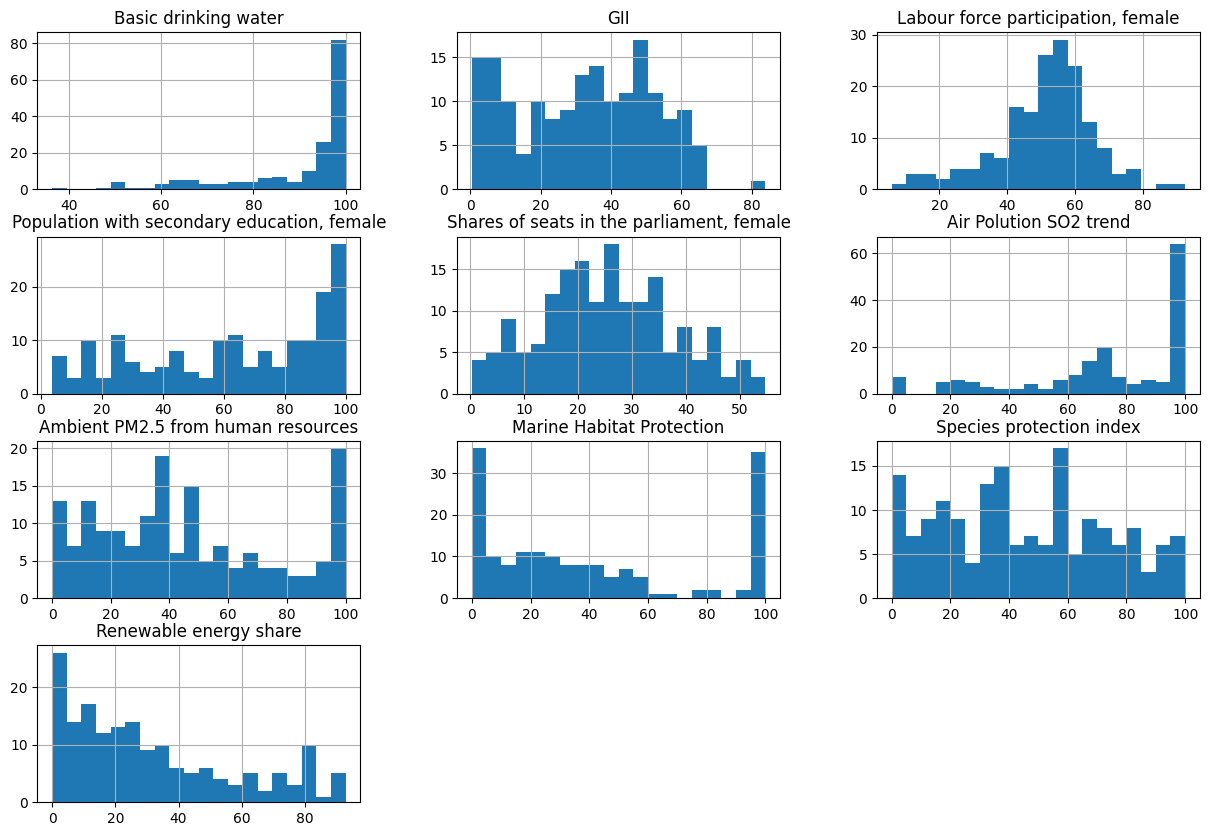

In [315]:
# Filter the data for year 2022
data_2022 = data[data['year'] == 2022]

# Select numeric columns except 'year'
numeric_cols = [col for col in data_2022.select_dtypes(include=np.number).columns if col not in ['year']]

# Plot histograms for 2022 data
data_2022[numeric_cols].hist(figsize=(15, 10), bins=20)

**Basic Drinking Water:** The distribution is right-skewed. It has a lot of entries at 100 and then quickly decreases in occurrences of lower values. This indicates that most countries already have nearly universal access to basic drinking water (values close to 100), but a smaller group has very low access. One can derive a global inequality in water access. While many countries plateaued near full coverage, a few are still progressing, and a minority lags far behind.

**GII:** The distribution suggests a bimodal distribution. There is an indication of two clusters, one group of countries with low inequality (developed nations) and another with medium inequality (developing nations). The higher values are barely reached. One could interpret it as a development divide between groups of countries. Additionally, there is a small bump at the 80 mark, indicating countries that have a very low GII.

**Labour force participation, female:** Most countries have moderate female participation rates (40-65%), with fewer countries having very low or very high rates (bell curve). Participation tends to centre around a global average, possibly constrained by cultural and traditional norms.

**Population with secondary education, female:** Education access is fairly spread but concentrated at the upper and a bit less at the lower end. Global educational attainment for women is improving, but not universally. There is a great difference in access, while a group of countries with very low female secondary education and another with very high attainment, there are a lot of countries in transition between these extremes.

**Share of seats in parliament, female:** Most countries have a rather low to moderate representation (10-35%), with fewer countries having very high representation. Progress toward political representation is uneven — only a few countries achieve gender parity. Generally, the values do not go towards 100% because one would expect 50% as being the desired ratio.

**Air polution SO2 trend:** The peaks suggest a split. While a lot of countries still have very high pollution trends, fewer countries have moderate to very little pollution. This indicates the difference in environmental policies. Developed countries have been aiming to reduce SO₂ emissions drastically, while other countries have not at all.

**Ambient PM2.5 from human resources:** The left skew means most countries have relatively low to moderate PM2.5 exposure (0–40), while a smaller group of countries have very high values near 100. This distribution indicates global inequality in air quality. Many nations enjoy relatively clean air, but a minority face severe pollution levels.

**Marine Habitat Protection:** Most coastal countries protect very little of their marine area, while landlocked countries are artificially at 100 (no marine area to protect). Marine conservation remains very limited globally.

**Species protection index:** Many countries do very little species protection, while only a few perform very well. Might reflect differences in biodiversity policy, data reporting, or resource availability.

**Renewable energy share:** Left-skewed distribution with a lot of countries with low renewable energy use. There is a cluster with high renewable adoption, indicating a strong divide between industrialised fossil economies and renewable leaders.

**Conclusion:** Global progress across social and economic dimensions is highly uneven. Many countries have achieved moderate to high levels in certain factors, while some countries still lag far behind, creating persistent inequalities. This pattern reflects a combination of development divides, policy differences and structural barriers.

## 3.2 Continent & Country Analysis

We decided we want to do some analysis based on continents instead of individual countries. Therefore, we verified that every continent is adequately represented, considering the number of countries on each continent in relation to the total number of countries in our dataset (Official Names of Countries 2021, 2025). The plot shows that Africa, Asia, Europe, and South America are moderately or well represented, whereas North America and Oceania are not. That is due to the fact that there are a lot of islands which are not well represented in the datasets we used for this project.

<Axes: title={'center': 'Representation ratio by continent'}, xlabel='continent', ylabel='Ratio'>

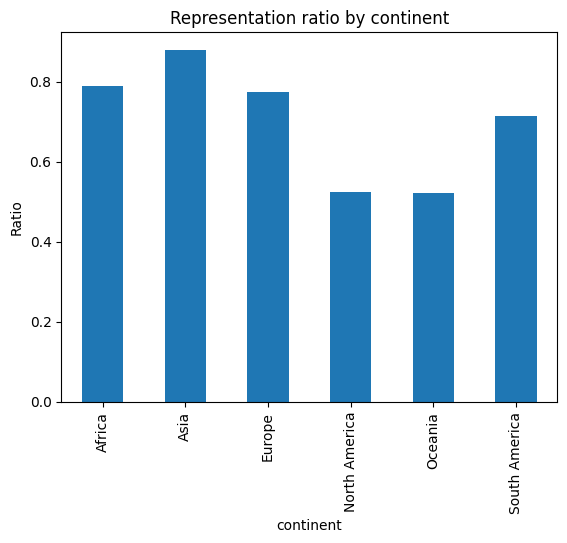

In [316]:
# Number of countries per continent
countries_total = {
    'Africa': 57,
    'Asia': 50,
    'Europe': 49,
    'North America': 40,
    'Oceania': 23,
    'South America': 14
}

# Calculate the ratio
counts = data.groupby('continent')['country'].nunique()
ratios = counts / pd.Series(countries_total)

# Create the bar plot
ratios.plot(kind='bar', title='Representation ratio by continent', ylabel='Ratio')

Next, we aimed to examine differences in the features across continents. To identify differences in spread or central tendency we used boxplots for each feature by continent. Later in our analysis the goal is to find clusters in countries but as a primary step it is interesting to see if we can already identify patterns within continents. In this step we aim to anayse the following questions:

How do continents differ in median values, variability, and outliers?
Which features show large regional disparities?

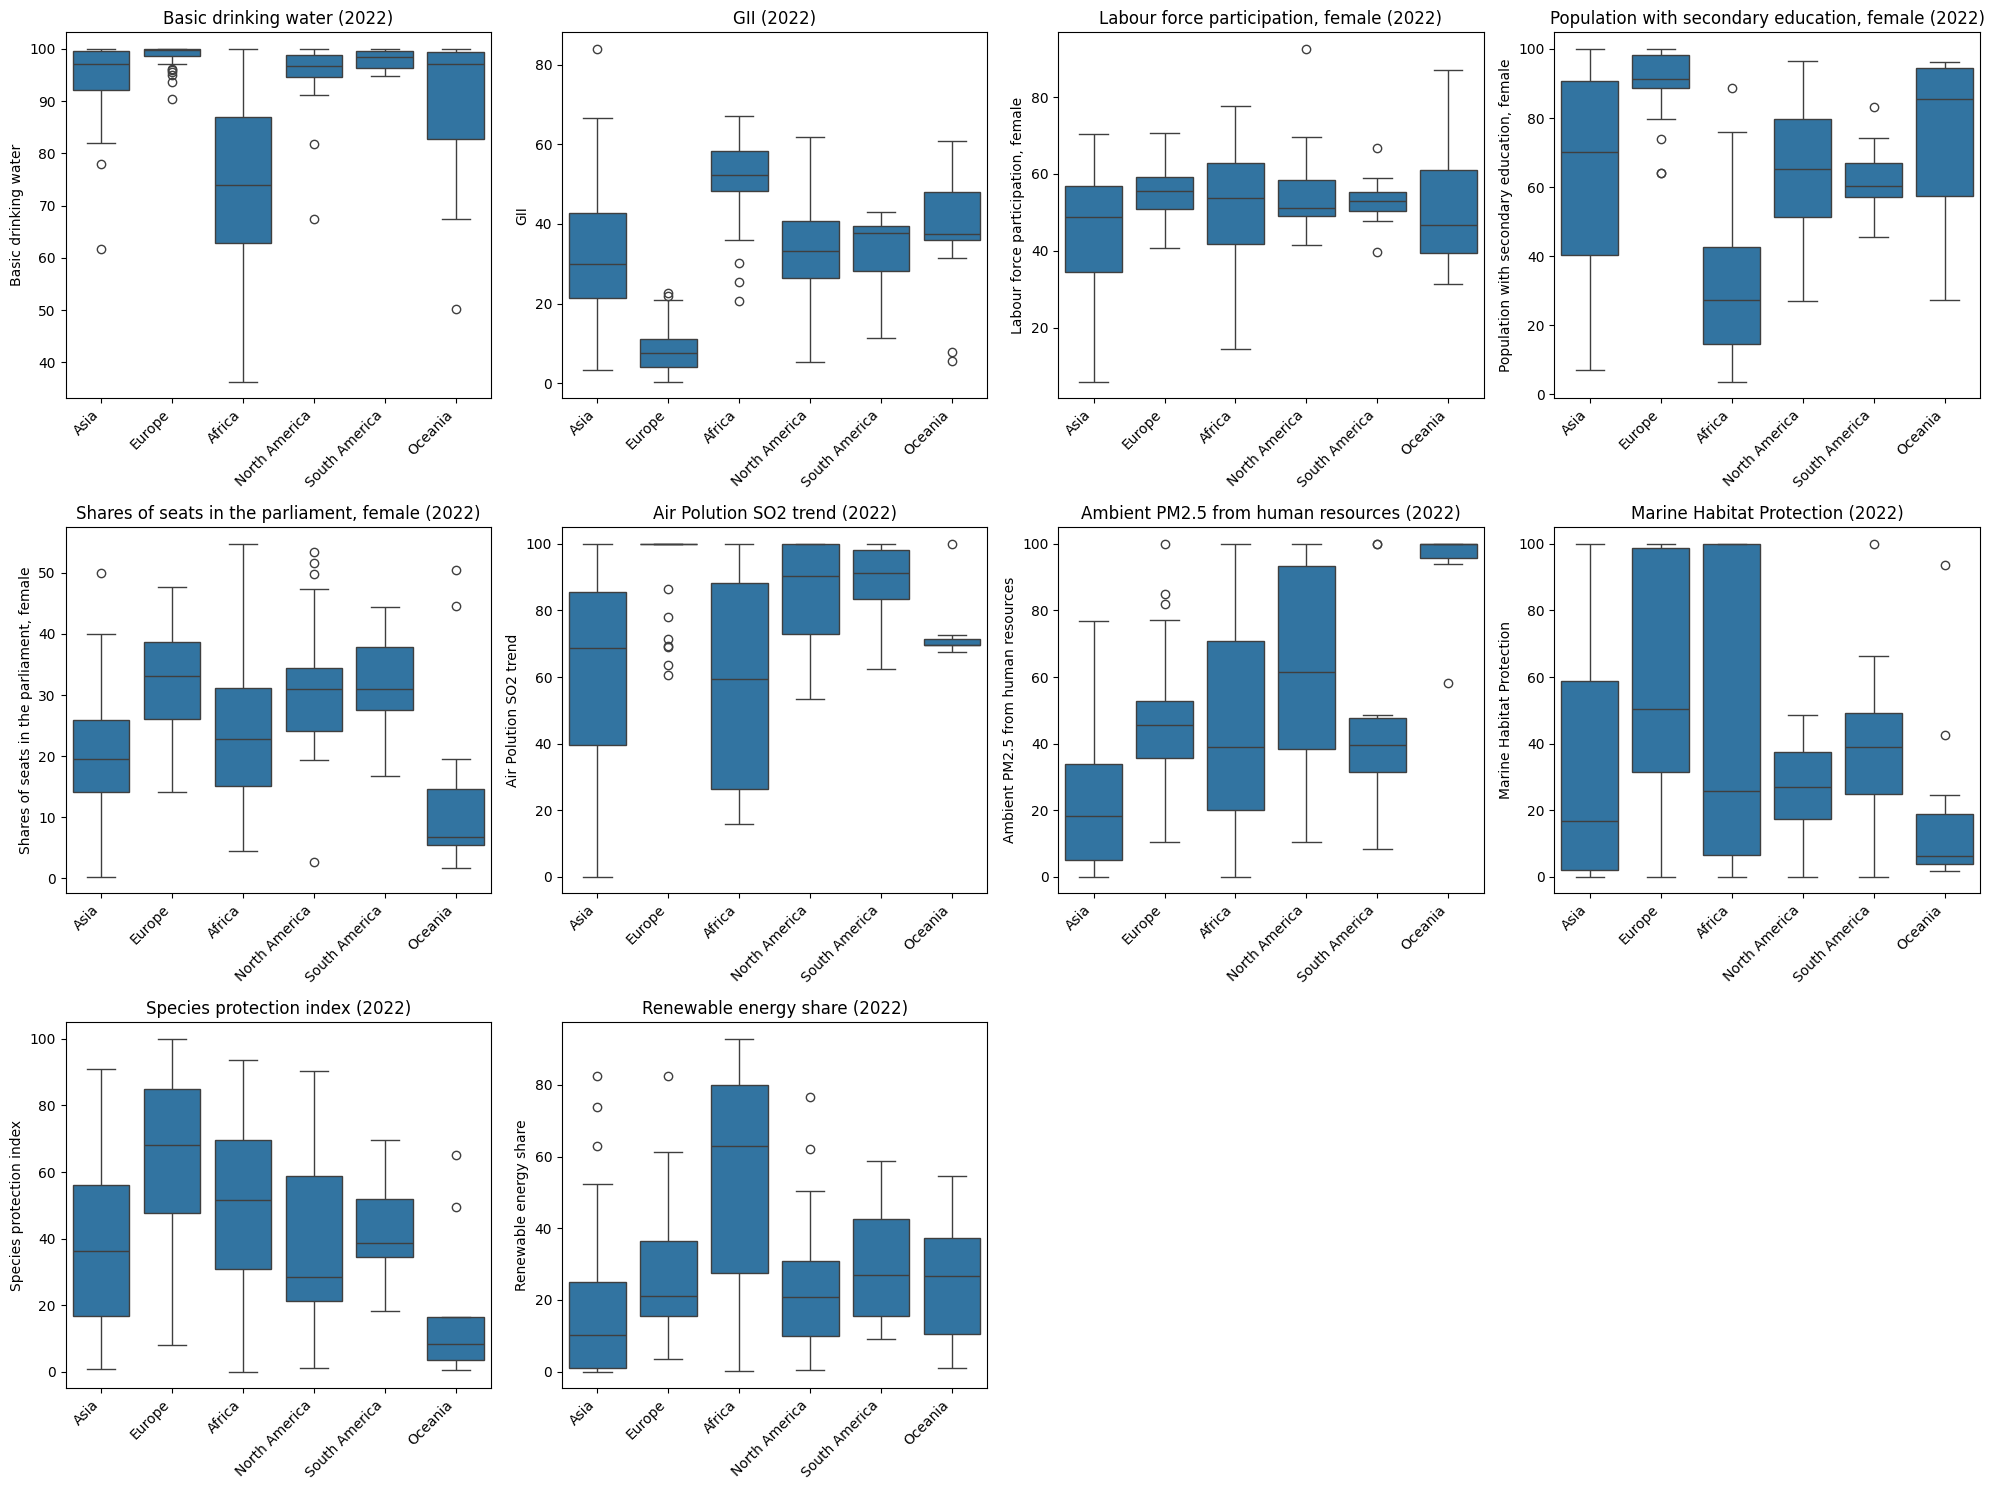

In [317]:
# Filter for only year 2022
data_2022 = data[data['year'] == 2022]

# Create the figure
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Plot a boxplot for each feature
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=data_2022, x='continent', y=col, ax=axes[i])
    axes[i].set_title(f"{col} (2022)")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=45)
    for tick in axes[i].get_xticklabels():
        tick.set_ha('right')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Basic drinking water:** Most continents are clustered near the top, showing high coverage. Africa stands out because its median is lower and whiskers are longer, indicating a greater variability in access. Asia has many low outliers, showing countries with much worse coverage than the median. Oceania and North America show a gap and then a line of outliers, indicating most countries have very high access, but a few lag far behind. Drinking water coverage is generally high, but Africa shows the largest disparities.

**GII:** Most continents are centred, with Europe positioned lower (less inequality) and Africa slightly higher (more inequality). Asia and North America have long whiskers spanning the axis, reflecting countries with very low or very high inequality. Gender inequality shows regional variability, with extremes present in Africa, Asia, North America and Oceania.

**Labour force participation, female:** Boxes are very central for most continents, indicating similar medians. Europe and South America have short whiskers. Africa, Oceania and Asia show long whiskers, suggesting more variability in female labour participation, so wider disparities.

**Population with secondary education, female:** Africa has a low median with a long upper whisker and outliers, reflecting some countries achieving high education while most remain low. Europe has a high median with a long lower whisker and a couple of outliers, showing some countries slightly behind the majority. South America has a very narrow box, indicating consistent moderate education. Asia and Oceania have high means, although the whiskers down are long, showing that, while generally these continents do well on education, there are still a few countries which are struggling to achieve good education for women.

**Shares of seats in the parliament, female:** Median values are similar across continents. Oceania has a lower median but a couple of upward outliers, indicating high female political representation. While general representation is similar, some continents have exceptional outliers. Long whiskers upward for Africa indicate that in some countries, there are more women in the parliament than men.
<img src="78c74f63ad9b068c0b53ca53324d40aed74f92f96368efaf74f967099e4776a8_1.jpg" width="400">

**Air polution SO2 trend:** Americas have very high values. Europe’s box is furthest at the top, with outliers extending downward, and very little visible variation in the median. Oceania is intermediate, with very little variance, whereas Asian and Africa have very high variance.

**Ambient PM2.5 from human resources:** Europe and South America in the lower half with moderate whiskers. Asia is slightly lower with a long upward whisker, Africa and North America are higher with long boxes, showing variability. Oceania is all at the top with a line of outliers down, reflecting extreme values.

**Marine habitat protection:** Europe and Africa have long boxes from top to mid, likely influenced by landlocked countries coded as 100, skewing the distribution. Other continents are generally lower, with high variability. The data is distorted by landlocked countries, but in general, marine protection shows high variability.

**Species protection index:** Most continents are in the lower half, indicating generally low species protection. Oceania is slightly lower, with many upward outliers (some countries doing much better). Species protection is low globally, but some outliers indicate success in isolated countries.

**Renewable energy share:** Most continents rank in the lower half of renewable-energy share, showing relatively slow uptake. However, Africa is an exception. While the overall share of renewable energy use remains low, several African countries, due to the hydropower, solar and wind deployments, have high shares of renewables in their electricity(International Renewable Energy Agency, 2011).

**Main findings:**
Africa consistently shows lower medians and higher variability in access to basic services (drinking water, secondary education, female labour participation), while Europe generally shows higher medians and lower variability. This pattern shows a global development disparity, with Africa facing challenges across several human development indicators, while Europe generally performs strongly, and other continents display mixed outcomes.

Features like renewable energy share, species protection, and marine habitat protection are generally low across continents, with high variability and some outliers. Africa’s high renewable energy values are unusual but can be explained by specific countries with high hydro or solar adoption which can not be taken as a representation of the continent as a whole.

Overall, human development indicators (water access, education, female participation) show clear continental patterns, while environmental and governance indicators are more heterogeneous.

Finally for this section we decided it is also useful to get insight on the individual countries, not just the continent level. Also the aspect of development over time has not really been explored yet. since this adds a lot of dimensions to the plot we created a interactive plot that is aimed at just getting a general idea of the data over time. We visaulized the GII and Renewable Energy Share as we consider these as two main indicators for our analysis.

In this step we can answer the questions:
How do features change over time regionally?
Are there regional clusters of high or low values?

In [318]:
# Function to create the interactive map for a specified feature
def plot_interactive_map (feature):
    if feature in ["GII"]:  # low values are good
        color_scale = px.colors.sequential.Viridis[::-1]  # reversed
    else:  # high values are good
        color_scale = px.colors.sequential.Viridis

    # Create the figure
    fig = px.choropleth(
        data_frame=data,
        locations="country",
        locationmode="country names",
        color=feature,
        hover_name="country",
        animation_frame="year",
        color_continuous_scale=color_scale,
        title=f"{feature} over time"
    )

    # Set the figure layout
    fig.update_layout(
        width=1200,      
        height=700,      
        coloraxis_colorbar=dict(
            title=feature,    
            thickness=25,  
            lenmode="fraction",
            len=0.8        
        ),
        title=dict(font=dict(size=20))  
    )

    fig.show()
    
# Plot the interactive map for GII and Renewable Energy Share
plot_interactive_map("GII")
plot_interactive_map("Renewable energy share")

C:\Users\lukav\AppData\Local\Temp\ipykernel_9544\281086876.py:9: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



C:\Users\lukav\AppData\Local\Temp\ipykernel_9544\281086876.py:9: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



For renewable energy share, countries such as Norway, Iceland, and Finland consistently outperform the rest of Europe, which itself demonstrates substantial improvement over time. Africa stands out with a remarkably high percentage, which aligns with findings from the United Nations Sustainable Development Group (2025). This high share is largely due to Africa holding 30 per cent of the world’s essential minerals for renewable technologies and 60 per cent of the world’s best solar resources. Interestingly, many African countries with the lowest levels of electricity access actually have the highest shares of renewables in their energy mix, highlighting a significant opportunity for the expansion and rollout of renewable energy across the continent.

In contrast, Oceania, North America and South America show relatively limited improvement over the period observed, with South America maintaining mid-range renewable energy levels and North America and Oceania remaining comparatively low. South Asia also presents largely moderate values. However, its performance declines slightly over time, which may reflect rapid industrialisation and growing energy demand outpacing renewable development. In Asia, you can observe big fluctuations between countries.

For the Gender Inequality Index (GII), North America, Europe, and Oceania generally outperform other regions and show slight improvements over time. Northern and Central Asia, as well as South America, display intermediate levels, while Africa and Southeast Asia lag behind. Overall, most regions demonstrate gradual improvements over the period analysed, with the notable exception of Yemen, which shows little to no progress.

**Conclusion:** Overall, both indicators show a general improvement over time. In addition, geographical location appears to be a strong determinant of the feature values. The maps further highlight the regional disparities that were already evident in the boxplots. However, individual countries can deviate noticeably from their continent’s overall pattern, which will be further examined in the following steps.

## 3.3 Correlation

Cpntinuing with our exploratory analysis we examine the correlation between features with a correlation map.
The idea was understand if there are unexpected correlations worth exploring.

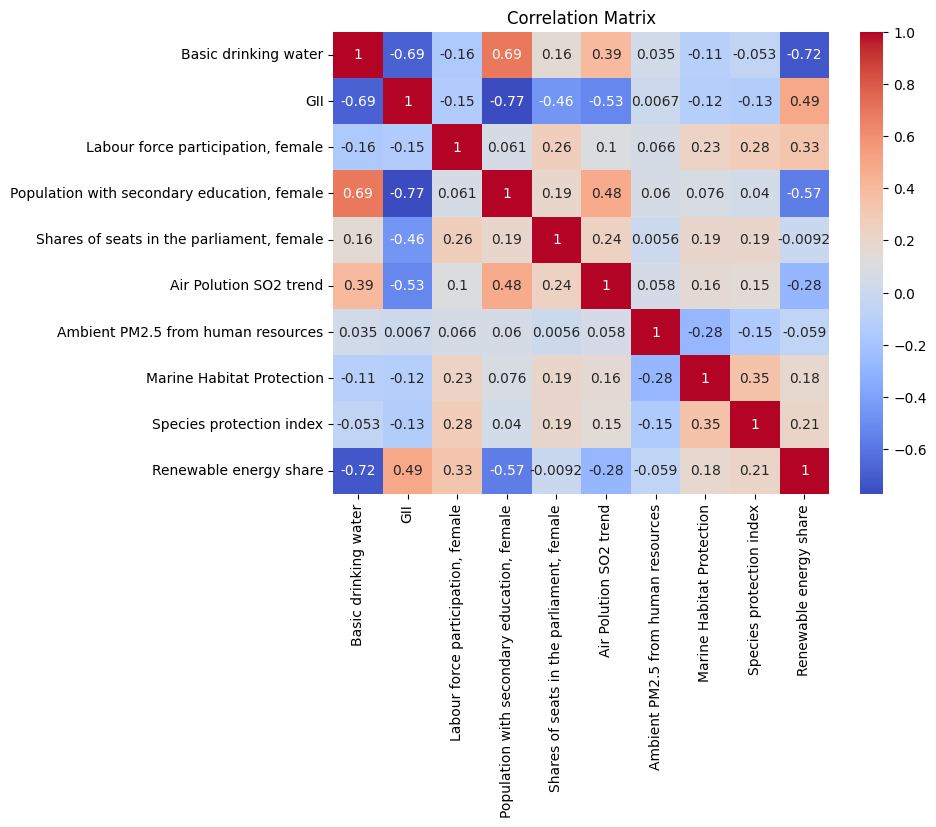

In [319]:
# Plot a correlation matrix for all features
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix we can see that  that the following pairs have interestingly high correlation (> |0.6|):
- Renewable energy share - Basic drinking water: -0.73
- GII - Basic drinking water: -0.69
- Population with secondary education, female - Basic drinking water: 0.69
- Population with secondary education, female - GII: -0.77

These correlations are largely intuitive. For example, countries with higher levels of education and better access to basic drinking water tend to have lower gender inequality and higher renewable energy adoption. Conversely, Ambient PM2.5 from human resources shows very low correlation with most other factors, suggesting that air pollution levels are largely independent of the social and governance indicators in this dataset.

In a second step we wanted to visualize the most interesting correlations in more detail. We chose to visualize them for 2000 and 2022 to see the difference in time using an interactive plot to be able to understand outliers withing the correlation patterns.
By doing this we can identify specific countries as outliers and see their development.

In [320]:
# Take the first and last year
data_2000_2022 = data[data['year'].isin([2000, 2022])]

# Identify correlated pairs > |0.6|
high_corr = []
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and 0.6 < abs(corr_matrix.loc[col1, col2]):
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)
                
# Loop through correlated pairs and create one figure per pair
for x_col, y_col in high_corr:
    fig = px.scatter(
        data_2000_2022,
        x=x_col,
        y=y_col,
        color='continent',
        facet_col='year',           # side-by-side plots for 2002 & 2022
        hover_name='country',       # show country on hover
        category_orders={'year':[2000, 2022]}, 
        title=f'{x_col} vs {y_col} (2000 vs 2022)'
    )
    
    fig.update_layout(
        width=1100,
        height=400,
        legend_title_text='Continent'
    )
    
    fig.show()


**GII - Basic drinking water:**
In 2002, the scatterplot of Basic Drinking Water versus GII shows that countries in Asia and Africa were concentrated in the high-inequality, low-water-access quadrant, whereas the other continents were mostly in the lower-right quadrant, indicating lower inequality and better access. Over time, Asian countries have made substantial improvements, moving towards lower GII and higher water access, while many African countries remain in the high-inequality, low-access region. Notable outliers include Yemen, which has maintained a very high GII and limited progress in water access, contrasting sharply with other Asian countries, and Haiti in North America, which also shows persistent challenges. For Oceania, you can see a similar trend as Africa, with a few countries such as Papua New Guinea, Solomon Islands and Kiribati not being able to improve significantly.

**Population with secondary education, female - Basic drinking water:**
A similar trend can be seen for Oceania, Africa and Asia in this relation. Again, we have Haiti as an outlier for North America on the negative side. Papua New Guinea, Solomon Islands, and Kiribati are challenged countries in Oceania. For Asia, Afghanistan, Cambodia and Yemen are not able to improve much differently from the rest of the Asian countries that show an improvement. Europe had Portugal, North Macedonia, Serbia, Albania and Lithuania as outliers, but over time they were able to follow the trend of European countries. Also, South America and North America show a general trend of improvement

**Renewable energy share - Basic drinking water:**
In 2002, the plot is scattered a lot, while the correlation seems to change over time. The trend for Oceania, Asia and Africa is again similar to the previous plots. Yemen is a weird outlier again, as well as Papua New Guinea, Solomon Islands and Kiribati. In Europe, Norway and Iceland are very high on the renewable energy share.

**Population with secondary education, female - GII:**
This one shows the strongest correlation, and it seems that it also increases over time. Yemen was once again an outlier, having high gender inequality index and low education for women. Portugal, North Macedonia, Serbia, Romania, Malta, Greece, and Spain spread from the rest of Europe, but in 2022, closer together.

**Conclusion:** Countries' progress in water access, gender equality, and environmental sustainability tends to be interrelated, with improvement of one factor often accompanying improvements in others. Over the explored period, quite a few countries in Asia and Europe have made substantial strides in reducing gender inequality. However, there are persistent challenges in parts of Africa, Oceania, and select countries such as Yemen, Haiti, and Papua New Guinea. Outliers highlight that progress is not uniform even within regions. Overall, global development is showing convergence among improving countries and challenges for lagging nations, which also reflects on the interconnected nature of social and environmental development.

## 3.4 Temporal Trends

In the final step of our exploratory analysis we want to dive more into temporal trends. We aimed to analyse if there are consistent improvements, stagnations, or declines over time. We begin by plotting the development of the individual features per continent.

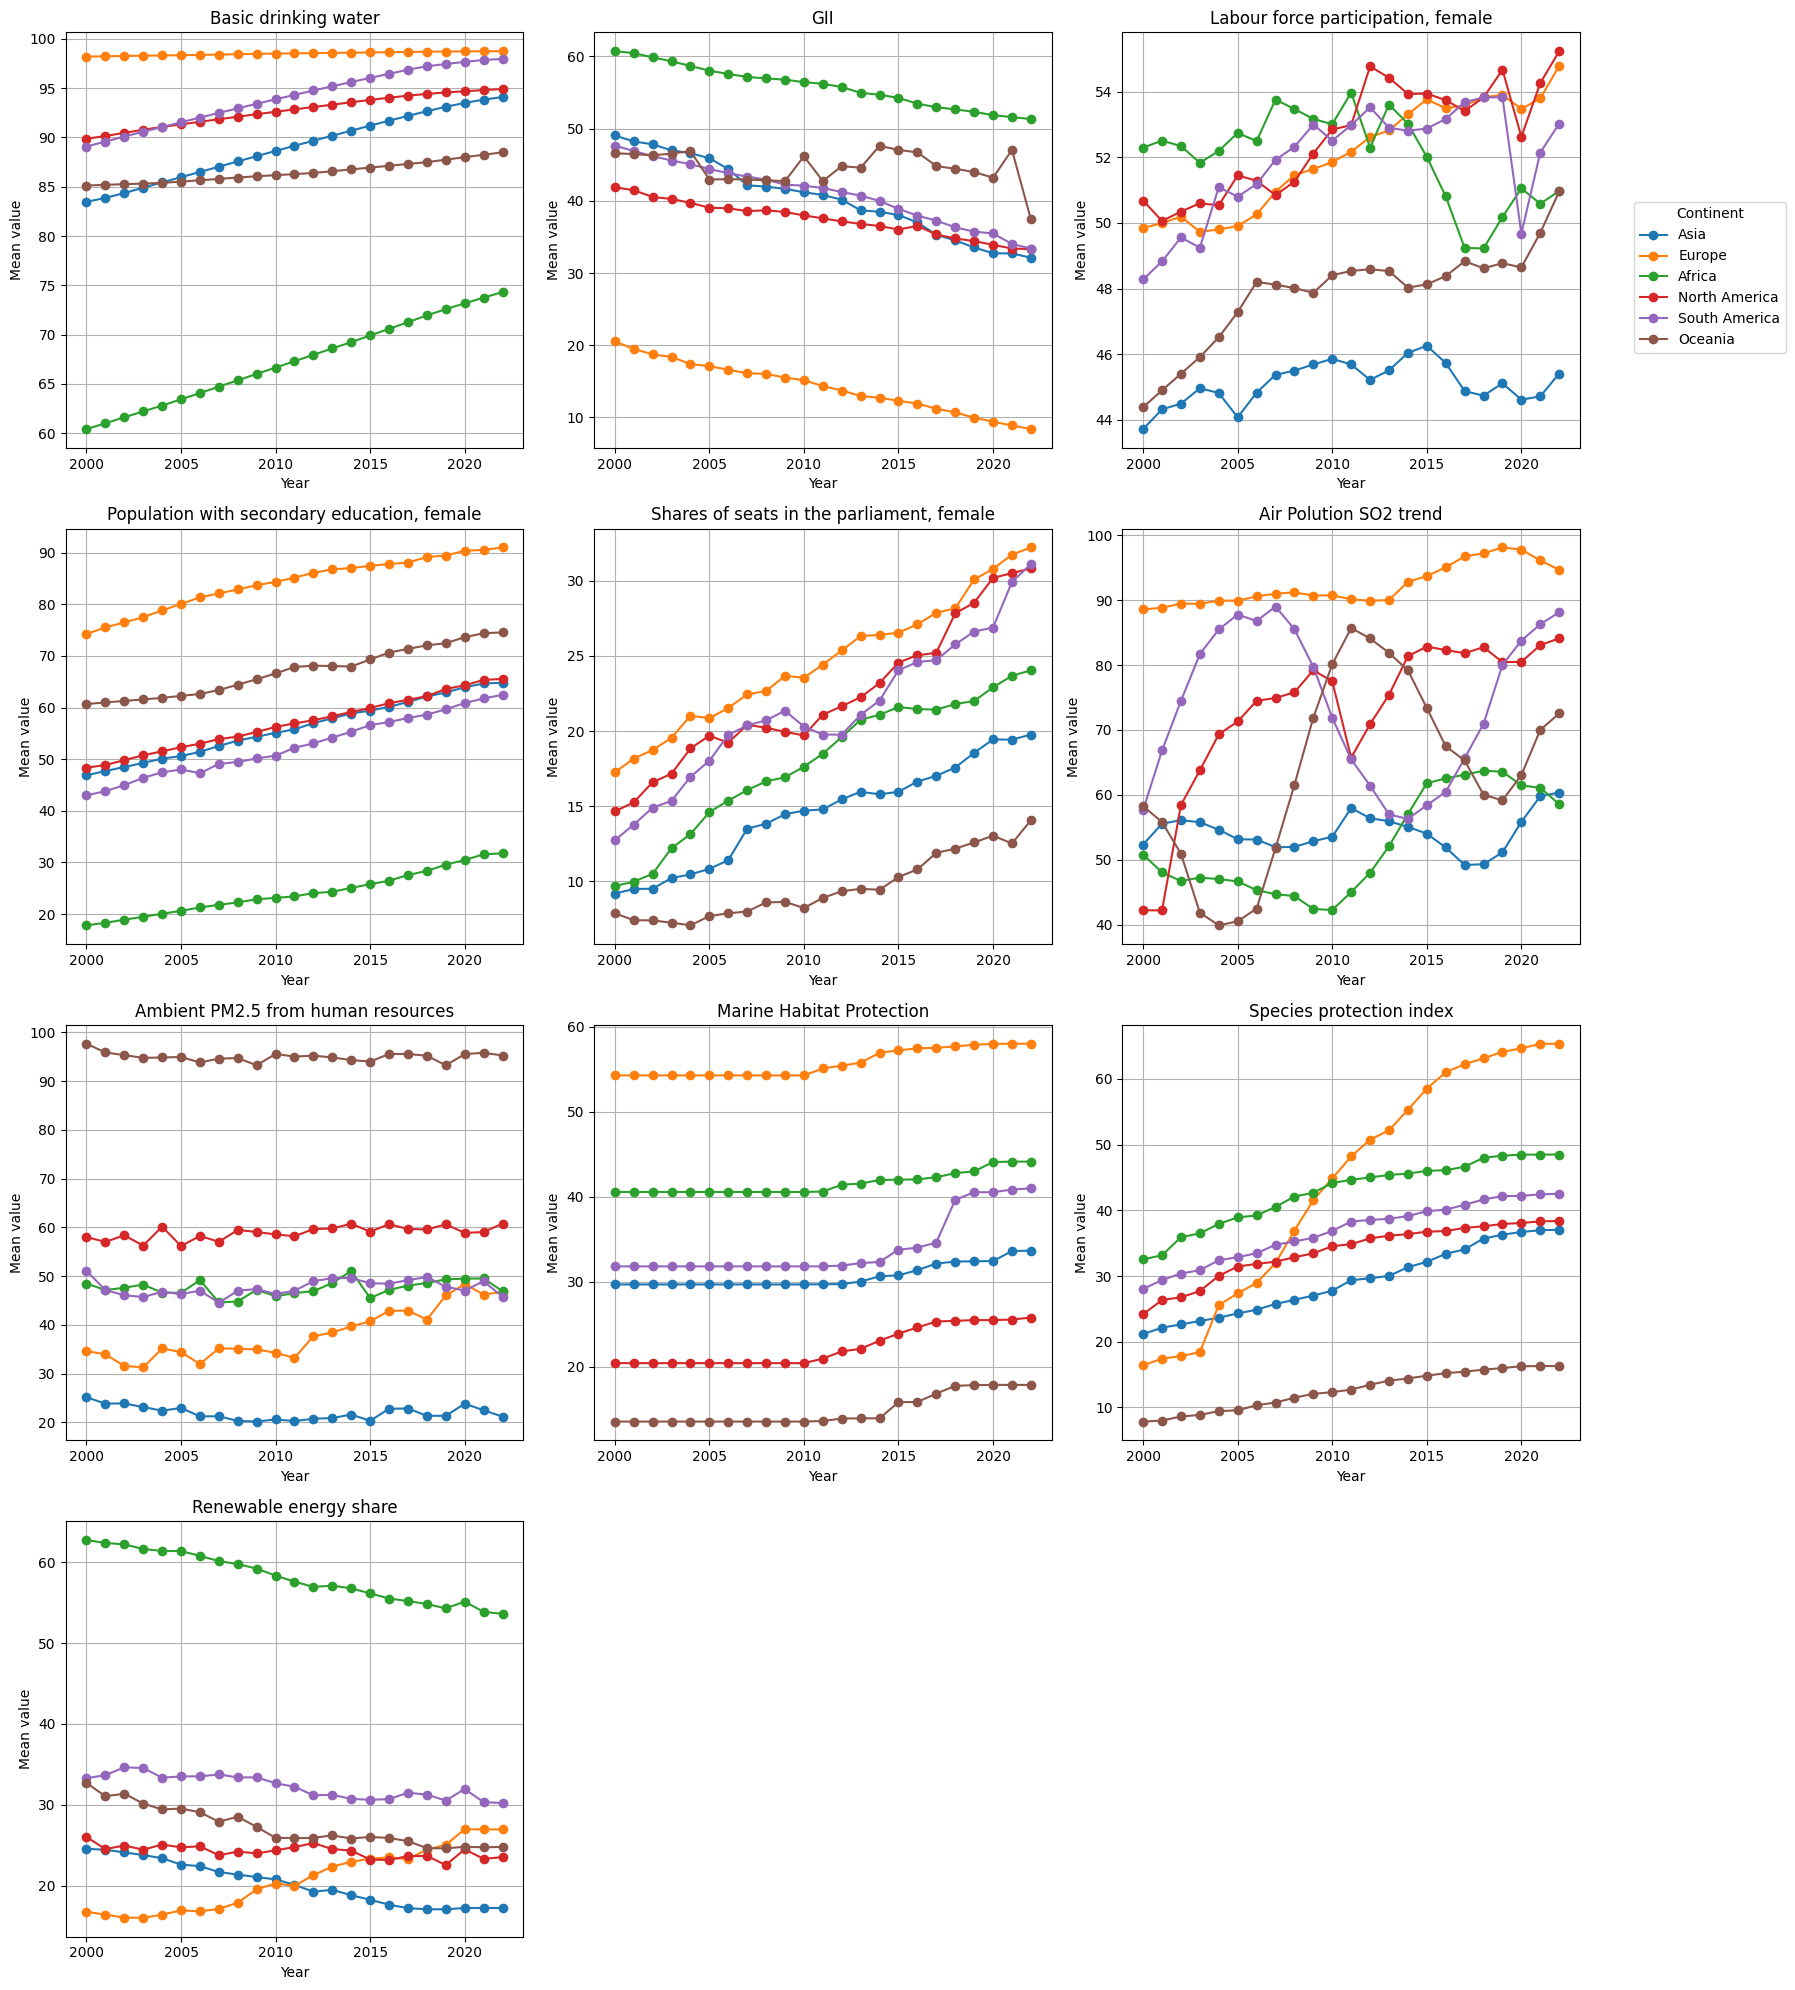

In [321]:
# Set the figure layout
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

# Create a trend plot for each feature
for i, feature in enumerate(numeric_cols):
    for continent in data['continent'].unique():
        continent_df = data[data['continent'] == continent]
        yearly_mean = continent_df.groupby('year')[feature].mean()
        axes[i].plot(yearly_mean.index, yearly_mean.values, marker='o', label=continent)
    
    axes[i].set_title(feature)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Mean value')
    axes[i].grid(True)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.legend(data['continent'].unique(), bbox_to_anchor=(1.02, 0.9), loc='upper left', title='Continent')

plt.tight_layout()
plt.show()


**Basic Drinking Water:** Most continents show an overall improvement over time. Some regions, such as Europe, North America, and Oceania, appear relatively stagnant, likely because countries with low access (e.g., Haiti or certain Oceania nations) remain at lower levels without substantial improvement. Africa shows a steeper increase, reflecting that it started from a lower baseline since early-stage development often leads to faster gains.

**Gender Inequality Index (GII):** All continents exhibit a declining trend, indicating gradual improvements in gender equality. This indicates that there is gradual progress for better health, education and economic opportunities for women. Oceania shows an anomalous pattern, which may warrant further investigation.

**Labour Force Participation, Female:** Participation rates are generally increasing, though there is a noticeable dip around 2019, likely due to the COVID-19 pandemic. The effect varies by continent, with Asia showing slower improvements, possibly due to high variability between countries within Asia.

**Population with Secondary Education, Female:**
Trends are steadily increasing across all continents, following a parallel pattern, indicating broad gains in female education. This reflects on the global effort to improve access to education and reduce disparities in schooling.

**Shares of Seats in Parliament, Female:**
All continents show a steady increase, reflecting gradual improvements in political representation for women. The parallel increase suggests that reforms and social attitudes are having a global impact. There is still plenty of room for disparity improvement.

**Air Pollution SO₂ Trend:**
Most continents show increasing pollution, often following an S-shaped curve, possibly linked to industrialisation. Europe and Asia are showing slightly less extreme changes, likely due to emission control measures. 

**Ambient PM2.5 from Human Resources:**
PM2.5 values are relatively steady over time, with little improvement. Trends are similar across continents, which suggests that the world is facing challenges in reducing fine particle pollution. Slow progress shows that current policies might not be a sufficient measure to combat emissions.

**Marine Habitat Protection:**
Marine habitat protection remained relatively stable until 2010–2015, after which there was a slight increase for all continents. This reflects that there is an expanding effort for international oceanic conservation. Despite the improvements, the pace is rather slow relative to threats of overfishing and pollution.

**Species Protection Index:**
All continents show steady parallel increases, showing ongoing efforts in biodiversity conservation. Europe stands out with a sharp improvement, achieving faster progress than other regions.

**Renewable Energy Share:**
Renewable energy share shows a declining trend across continents, except Europe, which exhibits consistent growth. North America remains relatively steady, while other regions show slight decreases, which reflects the rising energy demands outpacing renewable energy adoption.

**Conclusion:** Globally, there has been steady progress in gender-related indicators. However, environmental factors are revealing mixed outcomes: improvements exist in marine protection and species conservation, renewable energy in Europe, while other factors, like air pollution, are lagging behind, and renewable energy adoption is declining in most regions. Progress is uneven across continents, with Africa having rapid gains in a few indicators due to low initial baselines, Europe leading in sustainability and gender equality, and Oceania, Asia and select African countries having slow progress. Overall, the data shows correlated progress in social development and uneven environmental sustainability.

Finally, we analyze the correlations shift over time across continents to identify evolving regional development patterns.

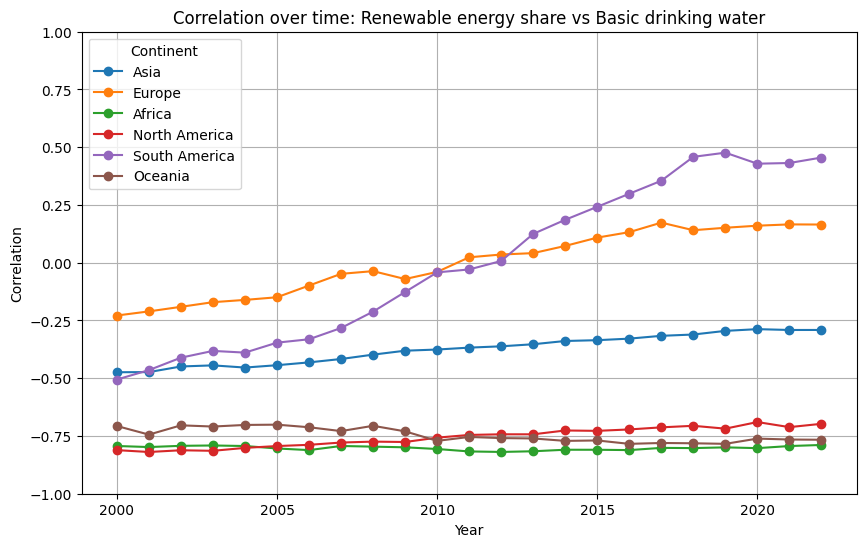

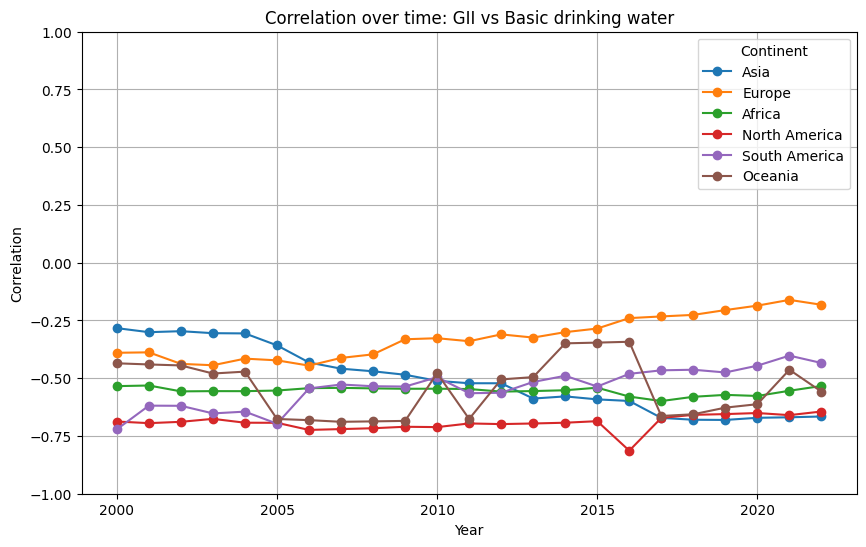

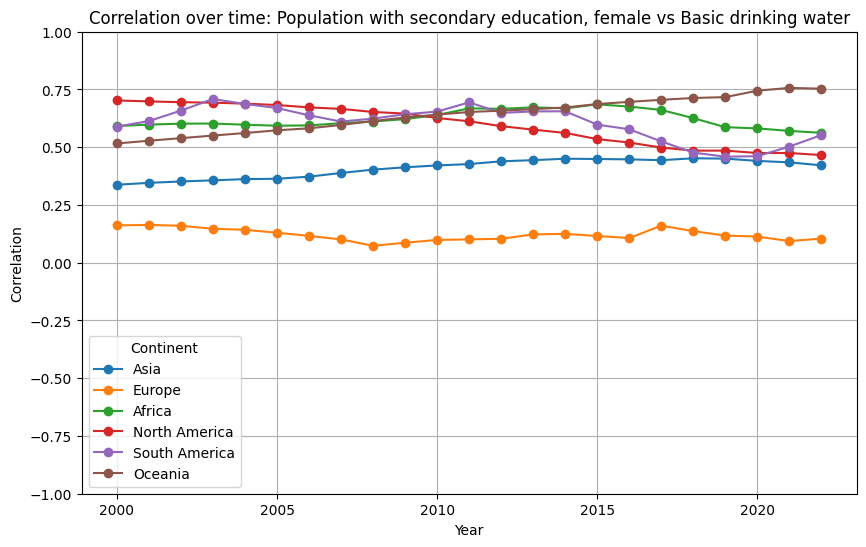

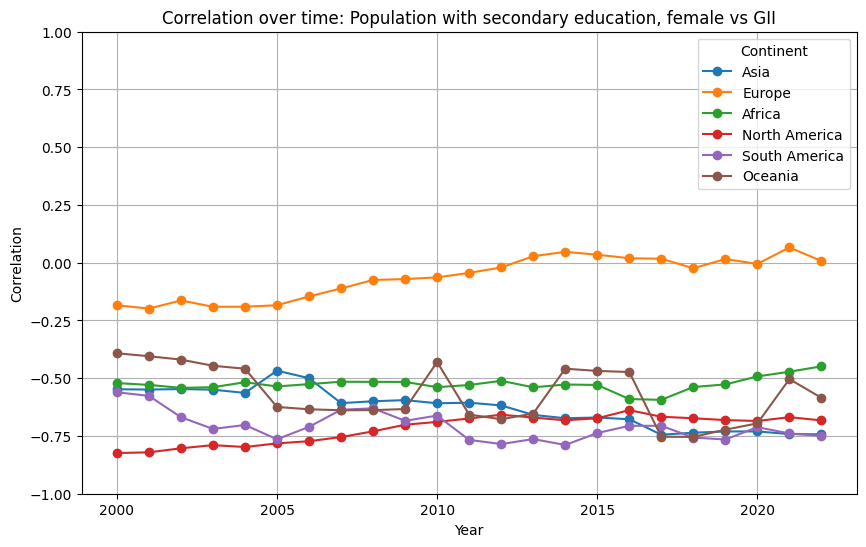

In [322]:
# Select main correlated pairs
main_pairs = [
    ('Renewable energy share', 'Basic drinking water'),
    ('GII', 'Basic drinking water'),
    ('Population with secondary education, female', 'Basic drinking water'),
    ('Population with secondary education, female', 'GII')
]

continents = data['continent'].unique()
years = sorted(data['year'].unique())

# Loop through each pair
for x_col, y_col in main_pairs:
    # Create a DataFrame to store correlations per continent per year
    corr_data = pd.DataFrame(index=years, columns=continents)
    
    for continent in continents:
        for year in years:
            subset = data[(data['continent'] == continent) & (data['year'] == year)]
            if len(subset) >= 2:  # need at least 2 countries to compute correlation
                corr_value = subset[[x_col, y_col]].corr().iloc[0,1]
            else:
                corr_value = None
            corr_data.loc[year, continent] = corr_value
    
    # Plot correlations over time
    plt.figure(figsize=(10,6))
    for continent in continents:
        plt.plot(corr_data.index, corr_data[continent].astype(float), marker='o', label=continent)
    
    plt.title(f'Correlation over time: {x_col} vs {y_col}')
    plt.xlabel('Year')
    plt.ylabel('Correlation')
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.legend(title='Continent')
    plt.show()


**Renewable energy share - Basic drinking water:**
North America, Africa, and Oceania consistently exhibit strong negative correlations, indicating that higher renewable energy adoption is associated with lower access to basic drinking water in these regions. Asia shows a slightly weaker negative correlation with a downward trend. In contrast, Europe and South America transition from negative to positive correlations over the period: Europe moves from -0.25 to 0.25, while South America shifts more dramatically from -0.5 to 0.5.

**GII - Basic drinking water:**
The correlations remain generally stable over time, with only minor fluctuations. Asia shows a trend toward a stronger negative correlation, suggesting that higher gender inequality is increasingly associated with lower access to basic drinking water. In contrast, Europe has a weaker correlation, which gradually decreases over time, indicating that the relationship between gender inequality and drinking water access is less pronounced in European countries.

**Population with secondary education, female - Basic drinking water:**
North America, South America, Asia, and Oceania show moderately strong positive correlations, generally ranging between 0.5 and 0.75. Oceania shows an increasing trend, while North America shows a slight decrease over time. South America also trends slightly downward, whereas Africa remains relatively steady. Asia starts lower, around 0.3, and increases slightly to approximately 0.4. Europe displays the weakest correlation, remaining mostly steady between 0.1 and 0.2, with a slight downward tendency.

**Population with secondary education, female - GII:**
In Europe, the correlation starts around -0.25 and gradually approaches zero, indicating a weakening relationship over time between female secondary education and gender inequality. For most other continents, the correlation remains strongly negative, ranging between -0.5 and -0.75, with only slight upward or downward trends. Oceania shows more variability, fluctuating within this range.

**Overall Conclusion:**
These correlation patterns highlight that the relationships between social, gender, and environmental indicators are highly context-dependent. Strong correlations in some regions indicate that improvements in one dimension often coincide with progress in another, while weaker or negative correlations suggest that development pathways can differ substantially across continents. Europe often shows weaker or changing correlations, reflecting more uniform or saturated levels of development, whereas Asia, Africa, and other regions exhibit stronger, more consistent associations, emphasizing the ongoing disparities in education, water access, gender equality, and renewable energy adoption worldwide.

# 4. Machine Learning 

We have seen that grouping countries by continents provides some meaningful insights, but is it really the most effective method of comparison?

This question motivated our Machine Learning analysis. To explore it, we use an unsupervised machine learning technique called clustering. This allows us to create country clusters with no asssigned labels. Within the learnt library of scikitlearn we used kmeans. Its algorithm assigns data points to centroids (the center of a cluster) interatively until the clusters are stable and the algorhithm converges.

In [323]:
oldest_idx = data.groupby('country')['year'].idxmin()
latest_idx = data.groupby('country')['year'].idxmax()

oldest = data.loc[oldest_idx, ['country'] + numeric_cols].set_index('country')
latest = data.loc[latest_idx, ['country'] + numeric_cols].set_index('country')
delta = latest - oldest

## 4.1. Set-up
### Algorithm (K-means)

In [324]:
def k_means_cluster(df, n_clusters=3, title='Clustering Analysis'):
    """
    Performs KMeans clustering, calculates centroids and feature importance,
    and visualizes clusters with Plotly and optionally centroids with a heatmap.

    Returns:
        labels: Cluster labels
        centroids_df: DataFrame of cluster centroids
        feature_importance: Series of feature importance (range across clusters)
        df_with_cluster: Original DataFrame with Cluster column
    """
    # ----- KMeans clustering with feature importance -----
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=df.columns)

    feature_importance = centroids_df.max() - centroids_df.min()
    feature_importance = feature_importance.sort_values(ascending=False)

    # ----- Attach labels to original DataFrame -----
    df_with_cluster = df.copy()
    df_with_cluster['Cluster'] = labels.astype(str)  # as string for Plotly colors

    return labels, centroids_df, feature_importance, df_with_cluster

First we will do a clustering analysis of gender equality and environmental sustainability overtime, comparing the clusters from the first year in the data set to the ones of the last year. We get the data from the most recent country in the dataset and the least recent one.

### Optimal number of clusters (Elbow method)

We will then use the elbow method to get the most optimal number of clusters that we will define in the next step. This method was followed according to https://www.w3schools.com/python/python_ml_k-means.asp.

The elbow method measures a value called inertia for possible numbers of clusters. Inertia  measures the  amount of variation within clusters (with an lower inertia being desirable). The elbow of the diagram is where inertia stops dropping significantly so that the clusters are significant but not too complex.

In [325]:
def elbow_method_subplot(ax, df, max_clusters=10, title='Elbow Method'):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    inertias = []
    K = range(1, max_clusters + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, algorithm='lloyd')
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    ax.plot(K, inertias, marker='o')
    ax.set_title(title)
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Inertia')
    ax.grid(True)

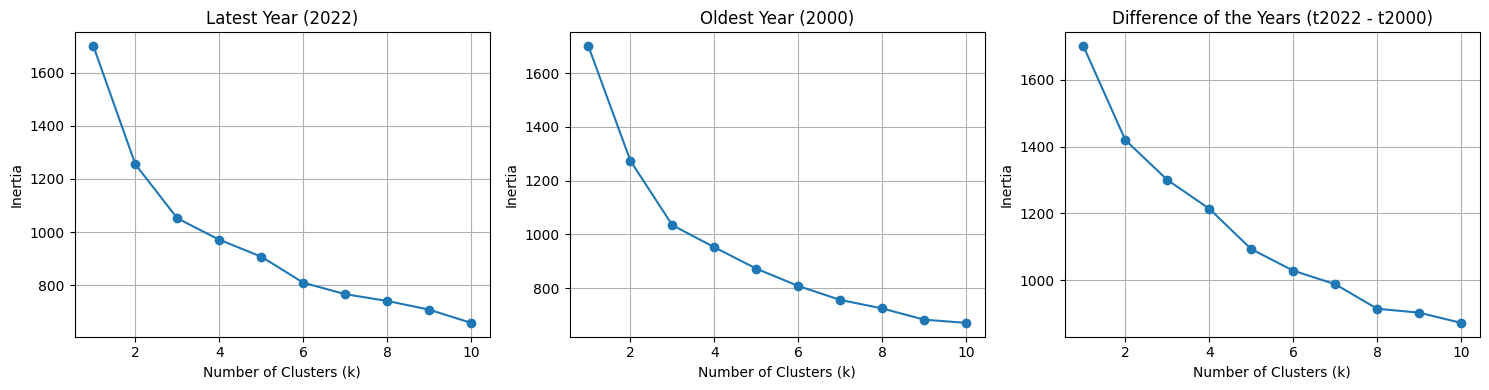

In [326]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

elbow_method_subplot(axes[0], latest, title='Latest Year (2022)')
elbow_method_subplot(axes[1], oldest, title='Oldest Year (2000)')
elbow_method_subplot(axes[2], delta,  title='Difference of the Years (t2022 - t2000)')

plt.tight_layout()
plt.show()

As the elbow seems to be 3 for both years, we will use it as the same amount of clusters. After, we create a function to find the clusters for each year with kmeans, an unspervised machine learning method.

### Visualizations

In [327]:
def plot_pca_clusters(df, cluster_col='Cluster', title='Cluster Visualization (PCA 2D)'):
    """
    Creates an interactive 2D PCA scatter plot of clusters using Plotly.

    Parameters:
    - df : pd.DataFrame
        DataFrame containing numeric features and a cluster column.
    - cluster_col : str
        Column name containing cluster labels.
    - title : str
        Plot title.
    """
    # Select numeric columns (exclude cluster column)
    numeric_df = df.select_dtypes(include='number').drop(columns=[cluster_col])
    clusters = df[cluster_col].astype(str)

    # Standardize and reduce to 2D
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(numeric_df)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Prepare DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df.index)
    pca_df[cluster_col] = clusters

    # Explained variance
    evr = pca.explained_variance_ratio_ * 100

    # Interactive scatter plot
    fig = px.scatter(
        pca_df,
        x='PC1', y='PC2',
        color=cluster_col,
        title=f"{title}<br><sup>PCA variance explained: PC1={evr[0]:.1f}%, PC2={evr[1]:.1f}%</sup>",
        hover_name=df.index,
        opacity=0.8,
        color_discrete_sequence=px.colors.qualitative.Set2
    )

    fig.update_traces(marker=dict(size=8, line=dict(width=1, color='black')))
    fig.update_layout(template='plotly_white', width=700, height=500, legend_title_text='Cluster')
    fig.show()

In [328]:
def plot_cluster_heatmap(centroids_df, title='Cluster Means', ax=None, cmap='Blues'):
    plt.figure(figsize=(10, 6))
    sns.heatmap(centroids_df, annot=True, cmap=cmap)
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Clusters')
    plt.show()

In [329]:
def perform_clustering(
    data,
    n_clusters=3,
    title='Title',
):
    """
    Perform K-Means clustering on a dataset, plot heatmap and PCA, and print summary.

    Parameters:
    - data (pd.DataFrame): Input data with countries as index.
    - n_clusters (int): Number of clusters for K-Means.
    - title (str): title for the graphs.
    """

    # Perform K-Means clustering
    labels, centroids, feature_importance, _ = k_means_cluster(data, n_clusters=n_clusters)

    # Plot heatmap of cluster centroids
    plot_cluster_heatmap(centroids, title=title + " Heatmap", cmap="Blues")

    # Add cluster labels to dataframe
    clustered_df = data.copy()
    clustered_df['Cluster'] = labels

    # Plot PCA 2D scatter
    plot_pca_clusters(clustered_df, cluster_col='Cluster', title=title + " Visualization")

    # Print countries per cluster
    print(f"Countries per cluster:\n")
    for cluster in sorted(clustered_df['Cluster'].unique()):
        countries = clustered_df[clustered_df['Cluster'] == cluster].index.tolist()
        print(f"Cluster {cluster} (size={len(countries)}): {countries}\n")

    # Print overall feature importance
    print(f"Overall feature importance for clusters (difference across clusters):\n")
    print(feature_importance)

## 4.2 Algorithm in action

### Oldest year clustering (2000)

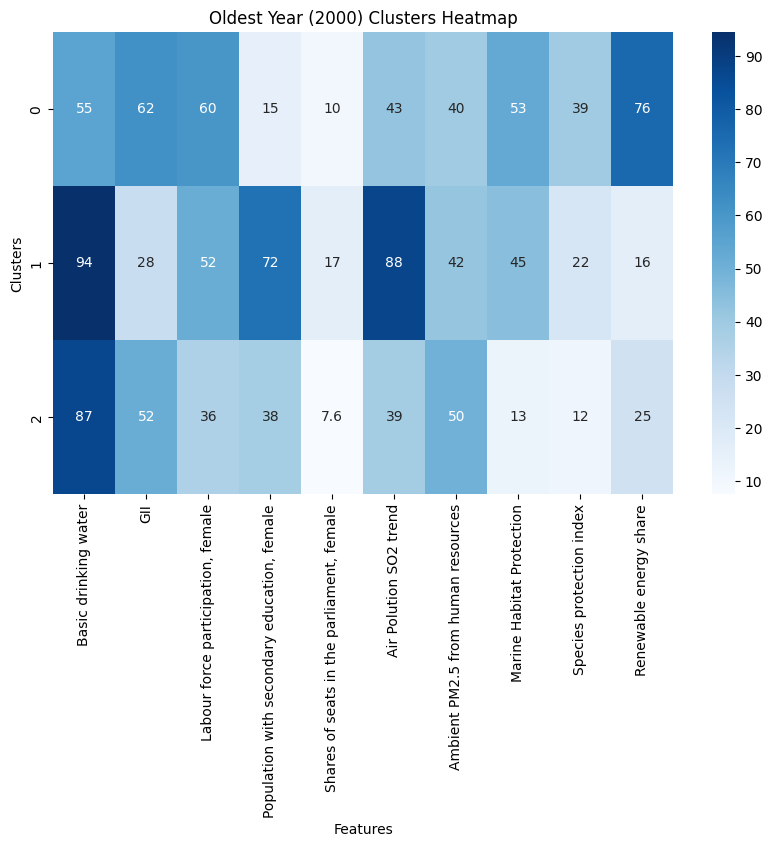

In [ ]:
perform_clustering(oldest, n_clusters=3, title='Oldest Year (2000) Clusters')

- Cluster 0 (n = 43): Low Gender equality, moderate environmental sustainability.
- Cluster 1 (n = 69): High gender equality, poor environmental performance.
- Cluster 2 (n = 58): Medium gender equality, poor environmental sustainability.

### Latest year clustering (2022)

In [ ]:
perform_clustering(latest, n_clusters=3, title='Oldest Year (2022) Clusters')

- Cluster 2 (n = 46): Medium gender equality, weak environmental sustainability .
- Cluster 1 (n = 91): High gender equality,  mixed environmental sustainability (higher on bioderversity than emissions or energy).
- Cluster 0 (n = 33): Low/medium gender equality, very high environmental sustainability.

### Difference of the years (2022 - 2000) clustering

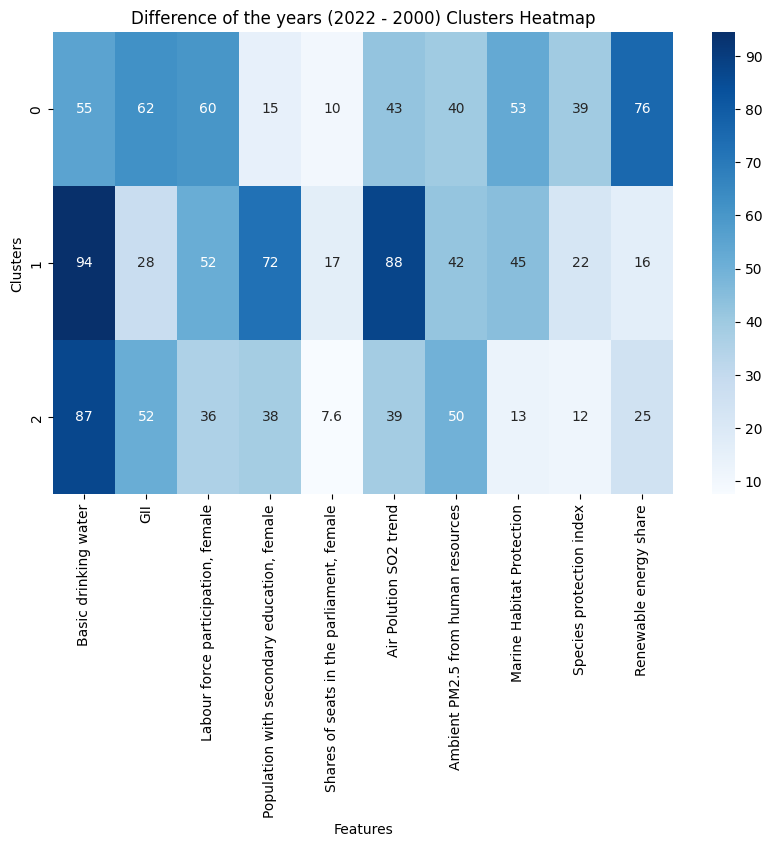

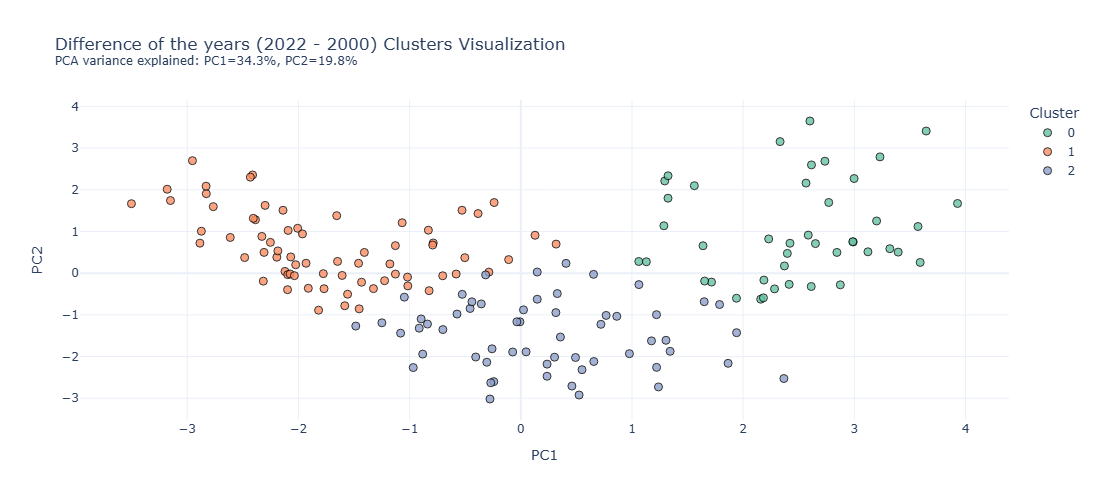

Countries per cluster:

Cluster 0 (size=43): ['Afghanistan', 'Angola', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Kenya', "Lao People's Democratic Republic", 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mozambique', 'Myanmar', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'Papua New Guinea', 'Paraguay', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sudan', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe']

Cluster 1 (size=69): ['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Barbados', 'Belarus', 'Belgium', 'Brunei Darussalam', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Cuba', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan', '

In [331]:
perform_clustering(oldest, n_clusters=3, title='Difference of the years (2022 - 2000) Clusters')

And finally we see the coefficients for each cluster of the two years. We can then compare the evolution of the relationship between Environmental sustainability and Gender Equality. Clusters 0 and 2 seem to have switched labels, so to analyse differences we switch them.

More countries join cluster 1 and the number of those in clusters 0 and cluster 2 are lower now. All clusters have higher gender equality: with lower GII, higher education levels and seats in the parliament and around the same labour force participation than before. They also slightly improve on environmental sustainability except in renewable energy share.

**TO DO:  explain the trend clustering**

Results in slope coefficients once again show that while gender equality has generally improved over time, environmental sustainability trends are more mixed. We can also perform PCA with this data.

We will also use Principal Component Analysis (PCA), a method that reduces the dataset’s many variables into just a few new ones called principal components which capture most  variation in the data. This will be used to see which variables are contributing the most to clustering.

# Discussion
Discussion. Interpret your results in relation to your research question. Highlight unexpected patterns, note limitations of your analysis. Relate the results back to the SDGs. Critical, deep interpretation; unexpected findings & limitations discussed; strong, wellintegrated references.


TO DO: Add map



# Conclusion
What did you learn? Answer your research questions concisely. Summarize main findings. Insightful synthesis highlighting contributions and broader significance.

# References
International Renewable Energy Agency. (2011). Africa. Www.irena.org. https://www.irena.org/How-we-work/Africa

IUCN. (2024). Gender equality for greener and bluer futures: Women’s leadership in nature-based solutions. https://iucn.org/sites/default/files/2024-03/2024-gender-equality-for-greener-and-bluer-futures.pdf

Ko, J. and Leung, C. K. (2025). Gender inequality and esg performance: a global analysis of governance, environmental, and social outcomes in 97 countries. Innovation and Green Development, 4(4), 100272. https://doi.org/10.1016/j.igd.2025.100272

Official Names Of Countries 2025. (2025). Worldpopulationreview.com. https://worldpopulationreview.com/country-rankings/official-names-of-countries

United Nations Sustainable Development Group. (2025, January 27). Decoding Africa’s energy journey: Three key numbers. https://unsdg.un.org/latest/stories/decoding-africa%E2%80%99s-energy-journey-three-key-numbers


# Reflection
Initially, our focus was on the relationship between gender inequality and environmental sustainability indicators. However, we realized that this direction was somewhat limited. We then shifted to analyzing regional similarities and contrasts based on continents, alongside machine learning-determined clusters.

We divided our working process into dataset selection and preprocessing, EDA with visualizations, and machine learning to work in parallel. We had frequent meetings to ensure that our progress remained coherent with the storyline and to redistribute new tasks. This structure worked well, although we occasionally needed to adjust our work based on group discussions to remain consistent. It allowed everyone to evenly apply their coding skills and the regular feedback was valuable to gain new perspectives and refine our visualizations and interpretations.

One of the main challenges we faced was producing a coherent storyline. After selecting the dataset, defining clear research questions, and choosing methods required us to reevaluate our work in the discussions we held. On a technical note, handling the dimensionality of the data with multiple years and countries was challenging, particularly for visualization. To address this, we often focused on the first and last year or aggregated data by continent to simplify visualization.

# AI Statement
This notebook was written within the course Programming for Data Science (EPA112A) of the Faculty of Technology, Policy and Management of Delft University of Technology. 
In writing this notebook, we: 
- used generative AI to improve the grammar, style and/or spelling of the text.
- used generative AI as coding assistants to help with debugging and generating small code snippets.